## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

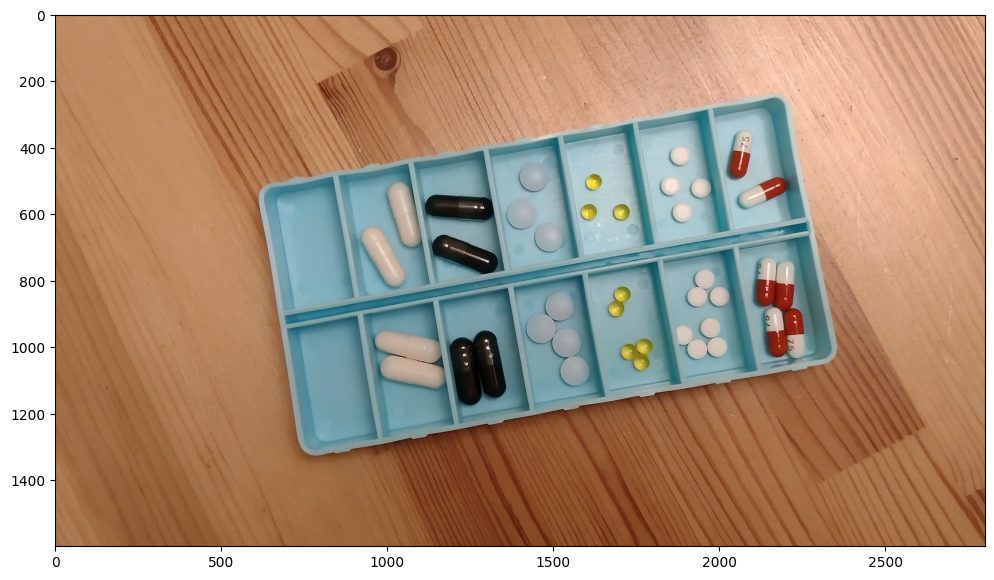

In [4]:
calib = cv2.imread('calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [12]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [18]:
def detect_objects(image, angle): 

    def convert_to_hsv(bgr_image):
        return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

    def create_color_mask(hsv_image, lower_bound, upper_bound):
        return cv2.inRange(hsv_image, lower_bound, upper_bound)

    def apply_rotation(image, rotation_angle):
        height, width = image.shape[:2]
        rotation_center = (width / 2, height / 2)
        rotation_matrix = cv2.getRotationMatrix2D(rotation_center, rotation_angle, scale=1.0)
        return cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC)

    def find_largest_connected_component(mask):
        edges = cv2.Canny(mask, 100, 200)

        kernel = np.ones((5, 5), np.uint8)
        closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        num_labels, labels = cv2.connectedComponents(closed_edges)

        max_label = 0
        max_size = 0
        for label in range(1, num_labels):
            size = np.sum(labels == label)
            if size > max_size:
                max_label = label
                max_size = size

        largest_component = np.zeros_like(mask)
        largest_component[labels == max_label] = 255

        return largest_component

    lower_blue = np.array([70, 20, 20], np.uint8)
    upper_blue = np.array([100, 255, 255], np.uint8)

    hsv_image = convert_to_hsv(image)
    mask = create_color_mask(hsv_image, lower_blue, upper_blue)

    rotated_mask = apply_rotation(mask, angle)
    rotated_image = apply_rotation(image, angle)

    largest_component = find_largest_connected_component(rotated_mask)

    x, y, w, h = cv2.boundingRect(largest_component)
    roi_from_image = rotated_image[y:y+h, x:x+w]
    roi_mask = rotated_mask[y:y+h, x:x+w]

    hsv_image = convert_to_hsv(roi_from_image)

    color_ranges = {
        PillType.PROBIO:  ([0, 0, 168], [50, 111, 255]),
        PillType.CARBON: ([0, 0, 0], [255, 100, 70]),
        PillType.KETO: ([50, 0, 168], [172, 111, 255]),
        PillType.ESPU: ([20, 80, 80], [35, 255, 255]),
        PillType.BIOX: ([0, 0, 168], [50, 111, 255]),
    }

    custom_hue_min = np.array([70, 20, 20], np.uint8)
    custom_hue_max = np.array([100, 255, 255], np.uint8)
    custom_mask = cv2.inRange(hsv_image, custom_hue_min, custom_hue_max)

    def create_masks(hsv_image, color_ranges, custom_mask):
        masks = {}
        for pill_type, (lower, upper) in color_ranges.items():
            lower = np.array(lower, dtype="uint8")
            upper = np.array(upper, dtype="uint8")

            mask = cv2.inRange(hsv_image, lower, upper)

            mask = cv2.bitwise_and(mask, mask, mask=~custom_mask)

            if pill_type == PillType.BIOX:
                x_threshold = hsv_image.shape[1] * 0.8
                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
                min_component_area = 600 
                max_component_area = 5000  
                
                medium_components = np.zeros_like(mask)

                for i in range(1, num_labels): 
                    component_area = stats[i, cv2.CC_STAT_AREA]
                    if min_component_area <= component_area <= max_component_area:
                        medium_components[labels == i] = 255

                mask = medium_components

                # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

                # filtered_components = np.zeros_like(mask)

                # for i in range(1, num_labels):
                #     x_centroid = centroids[i][0]
                    
                #     if x_centroid < x_threshold:
                #         filtered_components[labels == i] = 255

                # mask = filtered_components

            if pill_type == PillType.PROBIO:
                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

                min_component_area = 5000
                large_components = np.zeros_like(mask)
                for i in range(1, num_labels):
                    if stats[i, cv2.CC_STAT_AREA] >= min_component_area:
                        large_components[labels == i] = 255
                mask = large_components

            if pill_type == PillType.CARBON:

                kernel = np.ones((30, 30), np.uint8)

                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            if pill_type == PillType.KETO:
                kernel_size = 5  
                kernel = np.ones((kernel_size, kernel_size), np.uint8)

                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                kernel = np.ones((10, 10), np.uint8)

                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

                min_component_area = 800 
                large_components = np.zeros_like(mask)
                for i in range(1, num_labels):  
                    if stats[i, cv2.CC_STAT_AREA] >= min_component_area:
                        large_components[labels == i] = 255
                mask = large_components



            masks[pill_type] = mask

        return masks

    masks = create_masks(hsv_image, color_ranges, custom_mask)

    def draw_bounding_boxes_and_labels(image, masks):
        labeled_image = image.copy()
        for pill_type, mask in masks.items():
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(labeled_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(labeled_image, pill_type.name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return labeled_image

    labeled_image = draw_bounding_boxes_and_labels(roi_from_image, masks)

    return labeled_image, rotated_mask, roi_from_image, roi_mask, masks
    


In [19]:
def display_objects(image: np.ndarray, angle) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()

    labeled_image = detect_objects(image,angle)[0]
    rotated_mask = detect_objects(image, angle)[1]
    roi_from_image = detect_objects(image, angle)[2]
    roi_mask = detect_objects(image, angle)[3]
    masks = detect_objects(image, angle)[4]
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(rotated_mask, cv2.COLOR_BGR2RGB))
    plt.title("Rotated Mask")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(roi_mask, cv2.COLOR_BGR2RGB))
    plt.title("Extracted ROI")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(roi_from_image, cv2.COLOR_BGR2RGB))
    plt.title("Extracted ROI")
    plt.axis('off')
    plt.show()

    hsv_roi_pillbox = cv2.cvtColor(roi_from_image, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv_roi_pillbox)
    hist_h = cv2.calcHist([h],[0],None,[179],[0,179])
    plt.plot(hist_h, color='lightblue', label="hue")
    plt.title("Pillbox HSV")

    binarized_masks = {pill_type: cv2.bitwise_not(cv2.bitwise_not(mask)) for pill_type, mask in masks.items()}

    fig, axes = plt.subplots(1, len(binarized_masks), figsize=(20, 10))

    for ax, (pill_type, mask) in zip(axes, binarized_masks.items()):
        ax.imshow(mask, cmap='gray')
        ax.axis('off')
        ax.set_title(f'{pill_type.name}')

    plt.tight_layout()
    plt.show()

    plt.imshow(cv2.cvtColor(labeled_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected pills")
    plt.axis('off')
    plt.show()
    

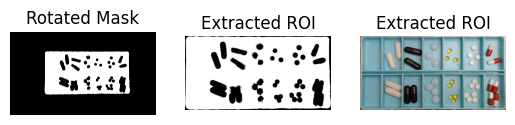

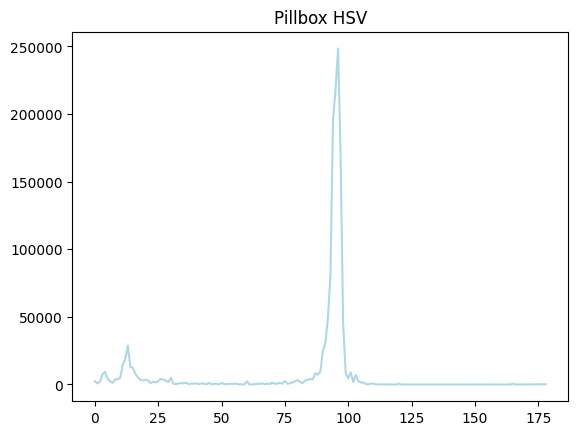

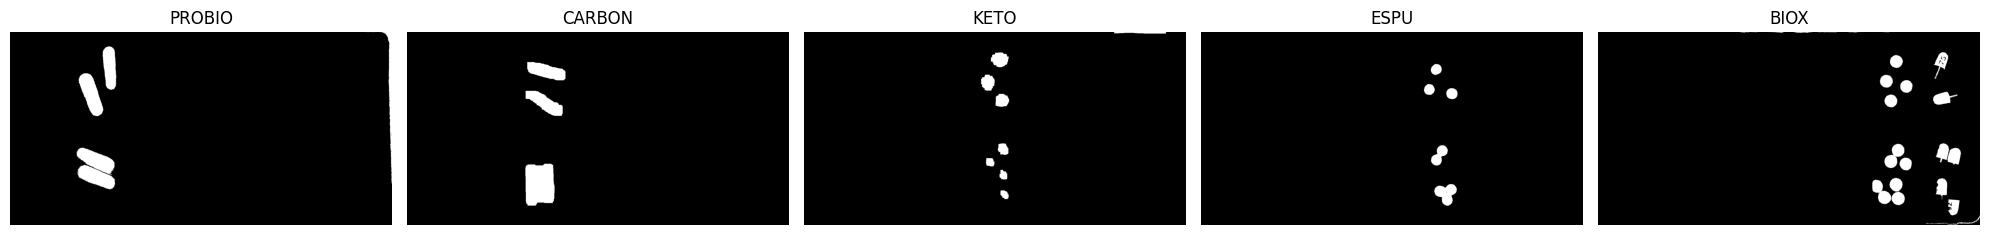

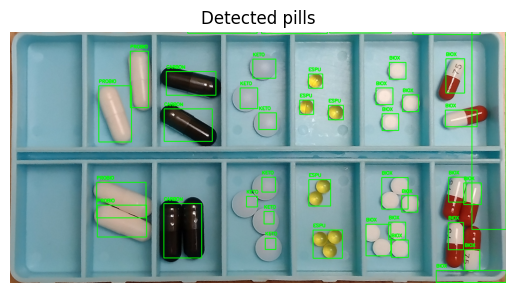

In [20]:
display_objects(calib, -10)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

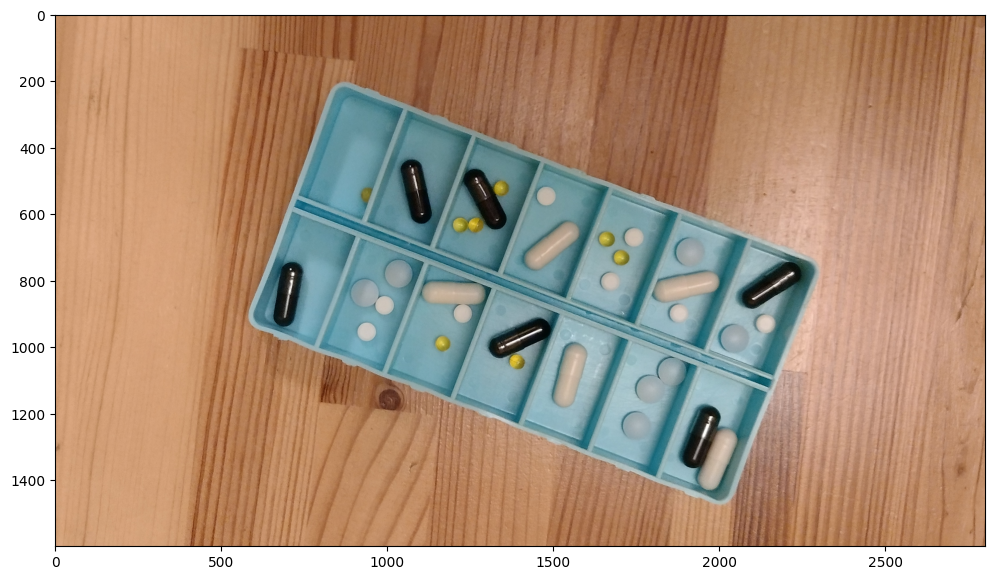

In [16]:
test = cv2.imread('test.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(test[..., ::-1]);

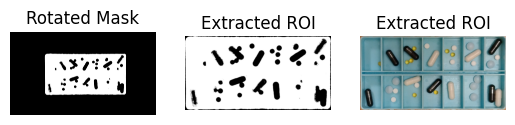

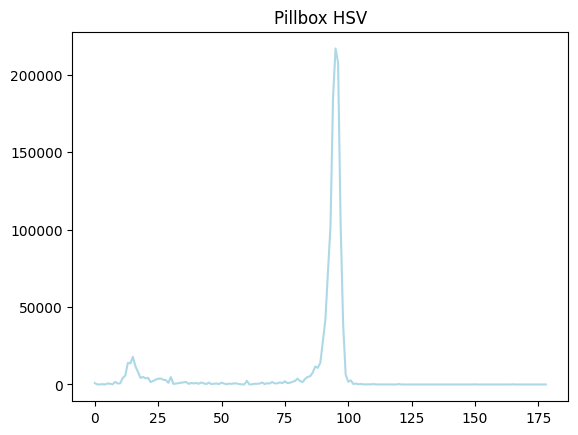

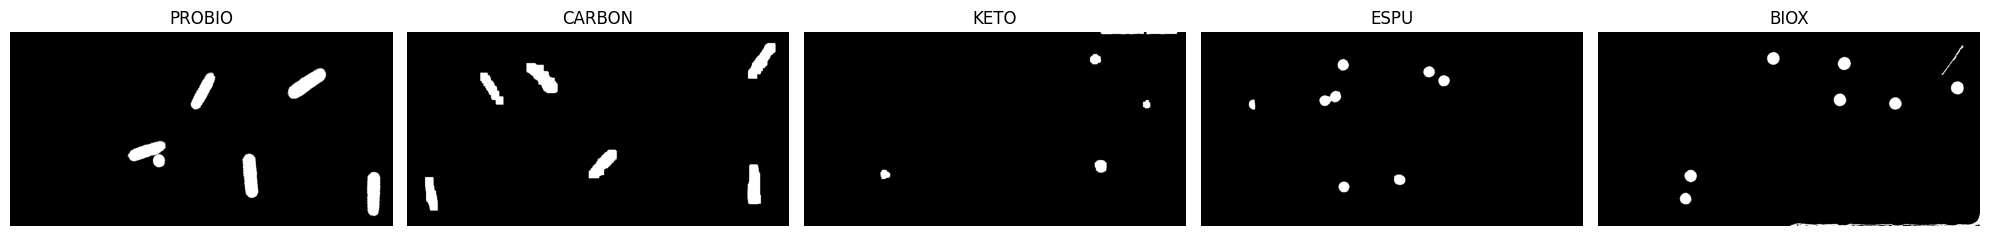

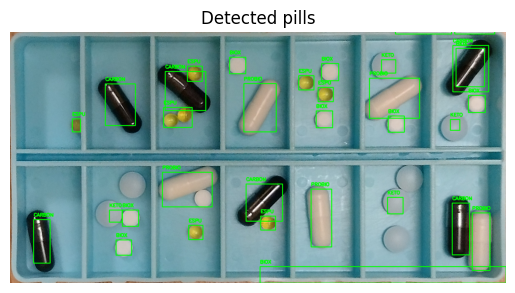

In [23]:
display_objects(test, 21)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.